# Library

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set(style='white')
%matplotlib inline

# Data Load

In [211]:
app = pd.read_csv("./archive/application_record.csv")
credit = pd.read_csv("./archive/credit_record.csv")

In [212]:
app.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0000,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0000
1,5008805,M,Y,Y,0,427500.0000,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0000
2,5008806,M,Y,Y,0,112500.0000,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0000
3,5008808,F,N,Y,0,270000.0000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0000
4,5008809,F,N,Y,0,270000.0000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0000


* 상환 실적 데이터

# EDA

In [213]:
app.shape, credit.shape

((438557, 18), (1048575, 3))

In [214]:
app.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,438557.0000,438557.0000,438557.0000,438557.0000,438557.0000,438557.0000,438557.0000,438557.0000,438557.0000,438557.0000
mean,6022176.2698,0.4274,187524.2860,-15997.9046,60563.6753,1.0000,0.2061,0.2878,0.1082,2.1945
std,571637.0233,0.7249,110086.8531,4185.0300,138767.7996,0.0000,0.4045,0.4527,0.3106,0.8972
min,5008804.0000,0.0000,26100.0000,-25201.0000,-17531.0000,1.0000,0.0000,0.0000,0.0000,1.0000
25%,5609375.0000,0.0000,121500.0000,-19483.0000,-3103.0000,1.0000,0.0000,0.0000,0.0000,2.0000
50%,6047745.0000,0.0000,160780.5000,-15630.0000,-1467.0000,1.0000,0.0000,0.0000,0.0000,2.0000
75%,6456971.0000,1.0000,225000.0000,-12514.0000,-371.0000,1.0000,0.0000,1.0000,0.0000,3.0000
max,7999952.0000,19.0000,6750000.0000,-7489.0000,365243.0000,1.0000,1.0000,1.0000,1.0000,20.0000


**Obseravation**

In [8]:
app.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [15]:
from IPython.core.display import HTML

def value_counts_all(df, columns):
	pd.set_option('display.max_rows',50)
	table_list=[]
	for col in columns:
		table_list.append(pd.DataFrame(df[col].value_counts()))
	return HTML(f"<table><tr> {''.join(['<td>'+table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

value_counts_all(app,app.columns)

,ID
7137299,2
7702238,2
7282535,2
7243768,2
7050948,2
...,...
5690727,1
6621262,1
6621261,1
6621260,1


**Obseravation**

**Observation**

* 중복된 ID 존재
* 휴대폰은 모두 소유하고 있지만, 직장 전화번호와 집전화번호는 없는 데이터가 존재
* Email을 가지고 있는 사람이 소수
* CNT_CHILDREN,CNT_FAM_MEMBERS에 이상치가 존재

In [215]:
app.drop_duplicates(subset=['ID'], inplace=True)

In [216]:
num_cols = app.select_dtypes(exclude='object').columns.tolist()
cat_cols = app.select_dtypes(include='object').columns.tolist()

# Feature Engineering

In [217]:
# '/' 제거
app['NAME_EDUCATION_TYPE']=app['NAME_EDUCATION_TYPE'].str.split('/',expand=True)[0]
app['NAME_FAMILY_STATUS']=app['NAME_FAMILY_STATUS'].str.split('/',expand=True)[0]
app['NAME_HOUSING_TYPE']=app['NAME_HOUSING_TYPE'].str.split('/',expand=True)[0]

In [218]:
#AGE
app['AGE']= round(-(app['DAYS_BIRTH']/365),0)

---

In [221]:
#map
status = {
    'X':0,
    'C':0,
    '0':1,
    '1':1,
    '2':1,
    '3':1,
    '4':1,
    '5':1
}

credit['STATUS']=credit['STATUS'].map(status)

agg = credit.groupby(['ID'])['STATUS'].sum().reset_index()
agg['STATUS']=agg['STATUS'].apply(lambda x : 0 if x==0 else 1)

# Merge

In [224]:
datasets = app.merge(agg)

# Preprocessing

In [225]:
#dataset
datasets.drop(['ID','DAYS_BIRTH'], axis=1, inplace=True)

<AxesSubplot:xlabel='STATUS', ylabel='count'>

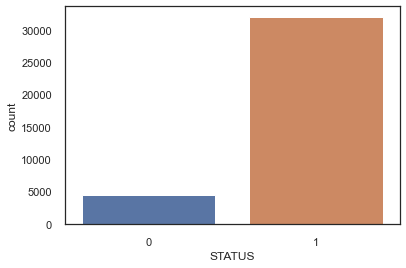

In [226]:
sns.countplot(datasets['STATUS'])

In [145]:
datasets.shape

(36457, 17)

In [204]:
train = datasets[:24305]
test = datasets[24305:]
target = test['STATUS']
test.drop(['STATUS'],axis=1, inplace=True)

In [206]:
X = train.drop(['STATUS'],axis=1)
y = train['STATUS']

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=.3, random_state=42)

In [163]:
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

In [207]:
le = LabelEncoder()

for i in cat_cols:
    X_train[i]=le.fit_transform(X_train[i])
    X_test[i]=le.transform(X_test[i])

In [208]:
from imblearn.over_sampling import SMOTE

# SMOTE 객체 생성
smote = SMOTE(random_state=42)

# 샘플링
X_train, y_train = smote.fit_resample(X_train, y_train)

# LIGHTGBM

In [197]:
from lightgbm import LGBMClassifier

In [210]:
clf = LGBMClassifier(random_state=42)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
accuracy_score(y_test, pred)

0.9897147558968733